###### May 11, 2022
###### Author: Lorenzo Meloncelli, Martina Manno, Valerio Schettini 
#### DATA VISUALIZATION PROJECT
# Amazon product co-purchasing network metadata

### Project objectives:

1. Create plots in order  to extract interesting insight from the data.
2. Extract a network from the dataset
3. Visualise your network

### Import libraries required

In [19]:
import string
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx 
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



### The dataset is available from the following link: 
### http://snap.stanford.edu/data/amazon-meta.html

In [2]:
df = open ('amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

### Description of the dataset
The dataset provides information about product metadata and review metadata on 548,552 different products. The data was collected in summer 2006 by crawling the Amazon website.
For each product the following informations are available:
- Title
- Salesrank
- List of similar products (that get co-purchased with the current product)
- Detailed product categorization
- Product reviews: time, customer, rating, number of votes, number of people that found the review helpful

The data format is:
- ID:product number
- ASIN: Amazon Standard Identification Number is a 10-character alphanumeric unique identifier assigned by Amazon.com for product identification
- Title: title of the product
- Group: the product groups can be Book, DVD, Video or Music
- Sales rank: the Amazon sales rank represents how a product is selling in comparison to other products in its primary category. The lower the rank, the better a product is selling
- Similar: ASINs of co-purchased products, such as people who buy X also buy Y
- Categories: location in product category hierarchy to which the product belongs (separated by |, category id in [...] )
- Reviews: product review information such as the total number of reviews, average rating and the individual customer review information including time, user id, rating, total number of votes on the review, total number of helpfulness votes which means how many people found the review to be helpful


 

### Dataset preprocessing

Initialize a nested product dictionary that will hold cleaned up amazon product data. 



In [3]:
amazonProducts= {}

Before analyzing the social network, some processes are required to use ASIN as the key and the others as the metadata associated with ASIN. 
- All the categories associated with the ASIN are concatenated, and then the are subject to Text Preprocessing steps: lowercase, stemming, remove digit/punctuation, remove stop words, retain only unique words. 
- The copurchased ASINs in the “similar” field are filtered down to only those ASINs that have metadata associated with it.

In [4]:
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

for line in df:
    line = line.strip()
    if(line.startswith("Id")):
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()
    elif (line==""):
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['DegreeCentrality'] = DegreeCentrality
            MetaData['ClusteringCoeff'] = ClusteringCoeff
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
df.close

<function TextIOWrapper.close()>

Filter Amazon products dictionary down to only Group=Book and write it to Amazon books dictionary.

In [5]:
#create book specific dictionary exclusively for books
amazonBooks = {}
for asin,metadata in amazonProducts.items():
    if (metadata['Group']=='Book'):
        amazonBooks[asin]=amazonProducts[asin]
        
#remove any copurchased items from copurchase list. If we don't have metadata associated with it
for asin, metadata in amazonBooks.items():
    amazonBooks[asin]['Copurchased']= ' '.join([cp for cp in metadata['Copurchased'].split() if cp in amazonBooks.keys()])
    

Use the copurchase data in Amazon books dictionary to create the copurchase graph structure as follows:
- NODES: are the ASINs
- EDGES: exist between two Nodes if the two ASINs were co-purchased
- EDGE WEIGHT: it is based on category similarity
- SIMILARITY: it is a measure between any two ASINs that were co-purchased and it can be calculated as the number of words that are common between categories of connected Nodes divided by the total number of words in both categories of connected nodes. The similarity range goes from 0 (most dissimilar) to 1 (most similar).

 

In [6]:
#create a product copurchase graph for analysis
#the graph nodes are product ASINs, the graph edge exists if two products were copurchased, with edge weight being a measure of category similarity between ASINs
copurchaseGraph = networkx.Graph()
for asin, metadata in amazonBooks.items():
    copurchaseGraph.add_node(asin)
    for a in metadata ['Copurchased'].split():
        copurchaseGraph.add_node(a.strip())
        similarity= 0
        n1= set((amazonBooks[asin]['Categories']).split())
        n2= set ((amazonBooks[a]['Categories']).split())
        n1In2 = n1 & n2 #intersection: number of words that are common between categories of connected nodes
        n1Un2 = n1 | n2 #union: total number of words in both categories of connected nodes
        if (len(n1Un2)) > 0:
            similarity = round (len(n1In2)/len(n1Un2), 2)
        copurchaseGraph.add_edge(asin, a.strip(), weight = similarity)

Add the graph-related measures for each ASIN node to the Amazon books dictionary: degree centrality and clustering coefficient.

In [8]:
dc = networkx.degree(copurchaseGraph)
for asin in networkx.nodes(copurchaseGraph):
    metadata = amazonBooks[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = networkx.ego_graph(copurchaseGraph, asin, radius = 1)
    metadata['ClusteringCoeff'] = round(networkx.average_clustering(ego), 2)
    amazonBooks[asin] = metadata

Now, write out Amazon books data to the amazon-books.txt file and the copurchase graph data to the amazon-books-copurchase.edgelist file.


In [9]:
df1 = open('./amazon-books.txt', 'w', encoding = 'utf-8', errors = 'ignore')
df1.write('Id\t' + 'ASIN\t' + 'Title\t'+
         'Categories\t' + 'Group\t' + 'Copurchased\t'+
         'SalesRank\t' + 'TotalReviews\t' + 'AvgRating\t'+
         'DegreeCentrality\t' + 'ClusteringCoeff\n')
for asin, metadata in amazonBooks.items():
    df1.write(metadata['Id'] + '\t' + 
              asin + '\t' +
              metadata['Title'] + '\t' +
              metadata['Categories'] + '\t' +
              metadata['Group'] + '\t' +
              metadata['Copurchased'] +'\t' + 
              str(metadata['SalesRank']) + '\t' +
              str(metadata['TotalReviews']) + '\t' +
              str(metadata['AvgRating']) + '\t' +
              str(metadata['DegreeCentrality']) + '\t' +
              str(metadata['ClusteringCoeff']) + '\n')
df1.close()

# write copurchaseGraph to file
df1 = open('amazon-books-copurchase.edgelist', 'wb')
networkx.write_weighted_edgelist(copurchaseGraph, df1)
df1.close()

# Plots


In [11]:
df2= open('amazon-books-copurchase.edgelist')
copurchaseGraph = nx.read_weighted_edgelist(df2)
df2.close()

In [22]:
### ??

In [20]:
def degree_rank(net):
    degree_sequence = sorted((d for n, d in net.degree()), reverse=True)
    df = pd.DataFrame(degree_sequence, columns = ['Degree'])
    fig = px.scatter(df, y = 'Degree')
    fig.update_layout(xaxis_title="Rank")
    return fig
#degree_rank(copurchaseGraph)

In [21]:
def degree_hist(net, kind = None, group = False):
    if kind == 'in':  degrees = net.in_degree()
    elif kind == 'out':  degrees = net.out_degree()
    else: degrees = net.degree()
   
    df = pd.DataFrame(degrees, columns = ['Node', 'Degree'])
    nbins = None if group else len(degrees)
    fig = px.histogram(df, x="Degree", nbins = nbins )
    fig.update_layout(yaxis_title="# of Nodes", bargap=0.01)
    return fig  

#degree_hist(copurchaseGraph)

# Network analysis


In [23]:
# check connection
nx.is_connected(copurchaseGraph)

False

In [24]:
# avg degree
sum(dict(copurchaseGraph.degree()).values()) / nx.number_of_nodes(copurchaseGraph)

5.482761044139568

In [25]:
# number of connected components
nx.number_connected_components(copurchaseGraph)

3840

In [26]:
# Average clustering coefficient
nx.average_clustering(copurchaseGraph)

0.40264425532861975

In [27]:
# The density tells us how many of the possible edges in the graph are actually present:
nx.density(copurchaseGraph)

2.028053325789754e-05

In [28]:
sum(nx.triangles(copurchaseGraph).values()) / 3

544744.0

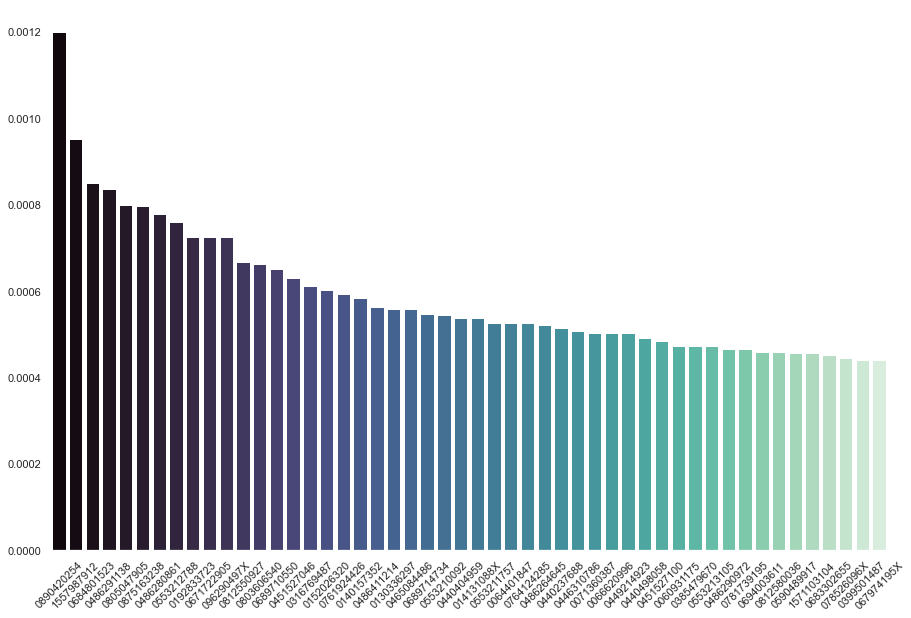

In [30]:
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
degree = [j for i,j in sorted_deg_cen_g_copurchase]
custom_palette1 = sns.color_palette("mako", 50)
custom_palette2 = sns.color_palette("light:b", 50)
custom_palette2.reverse()
sns.set(rc={'figure.figsize':(15,10), 'axes.facecolor':'white'})
ax = sns.barplot(x = ASIN, y = degree, palette = custom_palette1)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

In [37]:
mean_weights = []
for j in ASIN:
    neigh = copurchaseGraph.edges(j, data= True)
    weight = []
    for i in neigh:
        weight.append(i[2]['weight'])
    weight
    mean_weights.append(np.mean(weight))
mean_weights  
print('Mean of similarity between most connected nodes: ', np.mean(mean_weights))

Mean of similarity between most connected nodes:  0.41098937486463555


In [38]:
l = list(copurchaseGraph.edges(data= True))
total_weights = []
for i in l:
    total_weights.append(i[2]['weight'])
total_mean_weights = np.mean(total_weights)
print('Mean of similarity between all nodes: ', total_mean_weights)

Mean of similarity between all nodes:  0.513112637021605


The average weight of the edges of the nodes that have a higher degree centrality tends to be lower than the average total weight of the edges of the graph. therefore, the co-purchase of two books would seem not to derive exclusively from the characteristics of the books themselves, but also from other factors that are not taken into consideration here. we therefore advise not to develop a recommendation system that is only content-based, but a hybrid one that also takes into account other factors such as users' tastes.

# Network visualization

Given the problems the dimension of the dataset causes to its visualization, we decided to take a sample of it. Rather than selecting random nodes, we decided that a good criterion would have been that of selecting a small number of nodes with the highest degree centrality. This is because the nodes with this characteristic represent the books with the highest number of co-purchased ones, therefore this selection enables us to carry as much information as possible while still consistently reducing the number of observations.

In [40]:
df2 = open('amazon-books-copurchase.edgelist', 'r')
data = nx.read_weighted_edgelist(df2)
df2.close()
c = list(data.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []
deg_cen_g_copurchase = nx.degree_centrality(data)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'Source': fr, 'Target': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df = pd.DataFrame(edges)
df.to_csv('Highest degree centrality nodes.csv', index = False)

In [42]:
sample = pd.read_csv('Highest degree centrality nodes.csv')
sample = pd.DataFrame(sample)
g = nx.from_pandas_edgelist(sample, 'Source', 'Target', ['Weight'])

## Networkx

To get some insights from the new sample, we will first of all analyze its degeneracy.
A k-core of a graph G is a maximal connected subgraph of G in which all vertices have degree at least k. 
Equivalently, it is one of the connected components of the subgraph of G formed by repeatedly deleting all vertices of degree less than k. 
If a non-empty k-core exists, then, clearly, G has degeneracy at least k, and the degeneracy of G is the largest k for which G has a k-core.



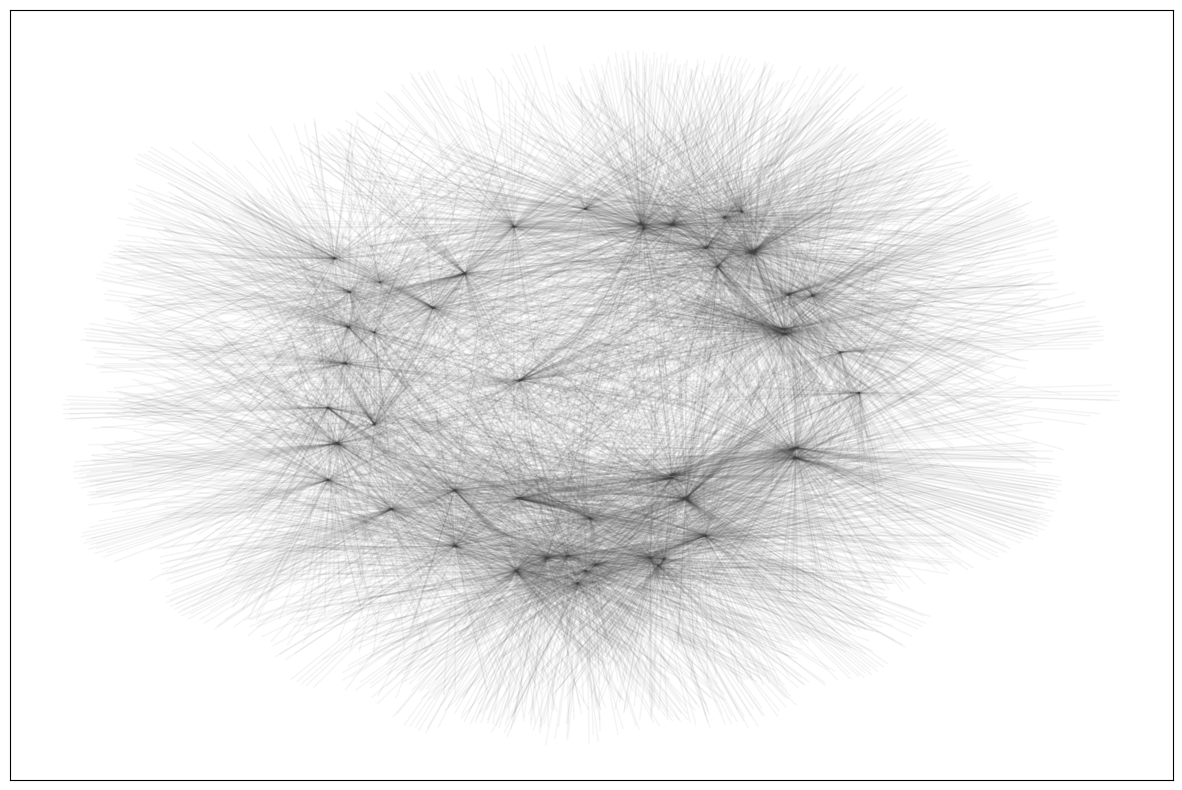

In [43]:
plt.rcParams.update(plt.rcParamsDefault)
pos = nx.spring_layout(g, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    g,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.06,
    with_labels=False)

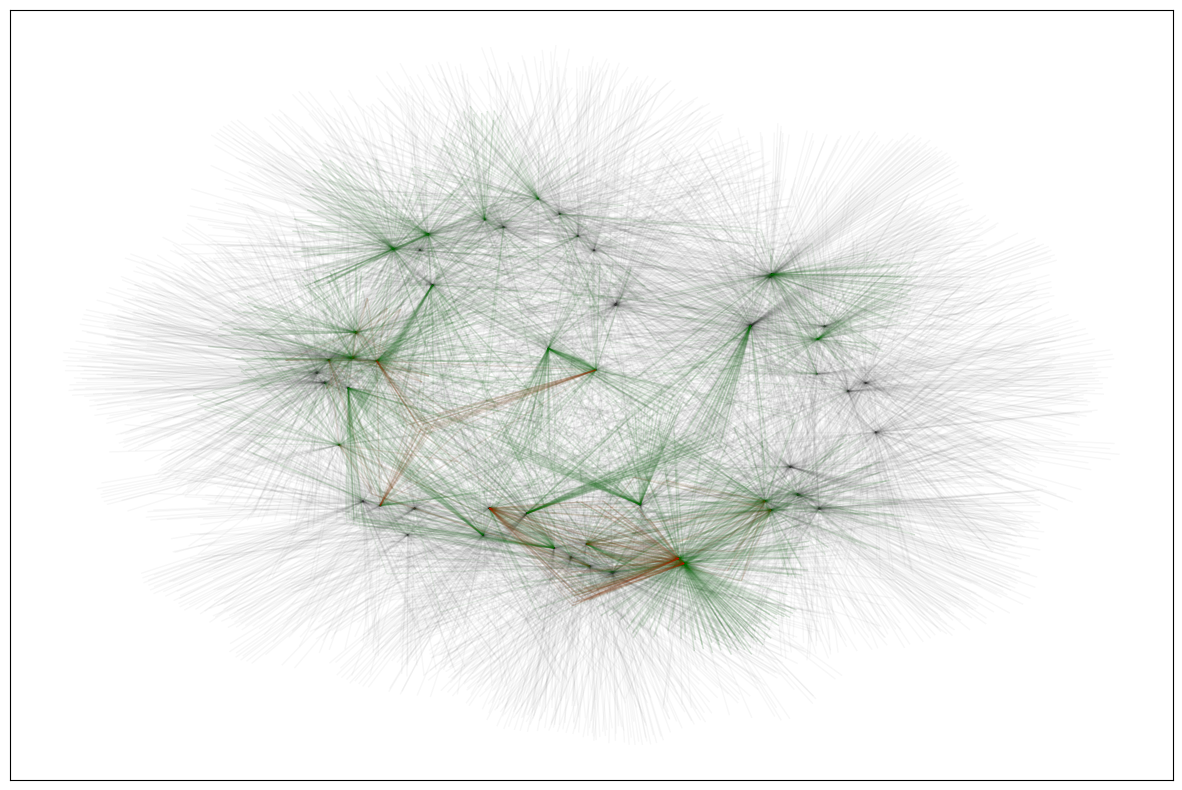

In [46]:
# Cores with at lest degree 2
G_core_2 = nx.k_core(g, 2)
# Similarly, with at least degree 3
G_core_3 = nx.k_core(g, 3)
# Visualize network and k-cores
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(g, k=0.1)
nx.draw_networkx(
    g, pos=pos, node_size=0, edge_color="#333333", alpha=0.04, with_labels=False)
nx.draw_networkx(
    G_core_2, pos=pos, node_size=0, edge_color="green", alpha=0.05, with_labels=False) 
nx.draw_networkx(
    G_core_3, pos=pos, node_size=0, edge_color="red", alpha=0.05, with_labels=False)

As you can see, only a few nodes in the graph have more than two neighbors (subgraph in red). 
In other words, it is rare to find set of books where each of the books has at least two other books purchased with it.
We also know that the sample graph we are we are referring to is made out of the 50 nodes with highest degree centrality. 
Therefore, in most cases we have books that are not co-purchased with each other, but with only one specific book, always present in the cart with the others.

(6288, 6288)


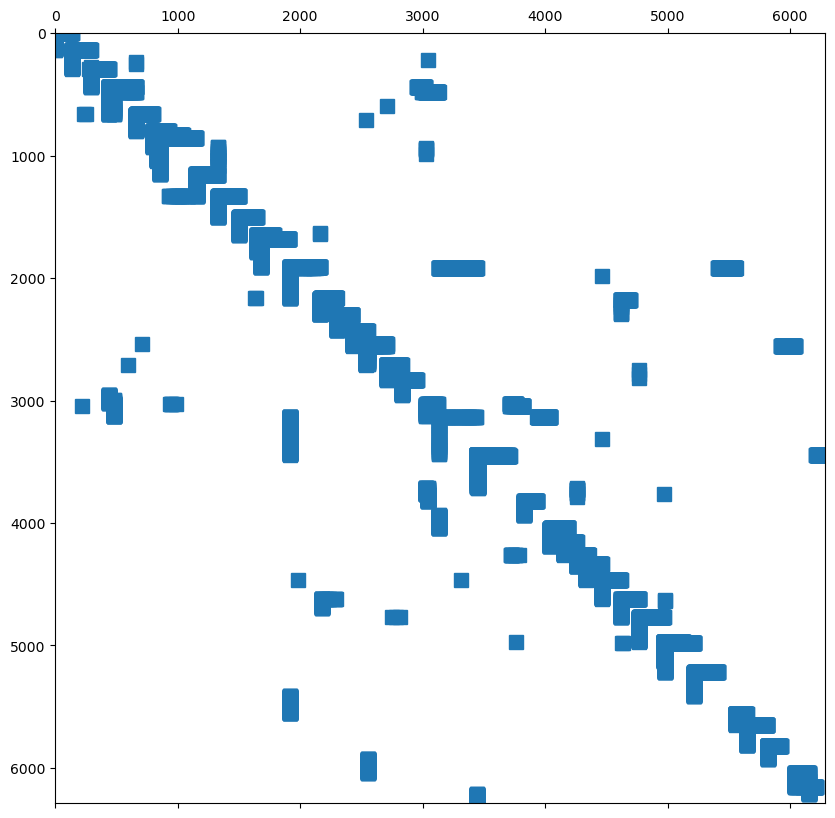

In [75]:
import matplotlib.pylab as plt
# Adjcency matrix for first 50 sorted nodes
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj = nx.adjacency_matrix(G, weight='Weight')
print(adj.shape)
plt.spy(adj)

In [79]:
df2 = open('amazon-books-copurchase.edgelist', 'r')
data2 = nx.read_weighted_edgelist(df2)
c = list(data2.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []
deg_cen_g_copurchase = nx.degree_centrality(data2)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[50:100]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges2 = {'Source': fr, 'Target': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df_adj2 = pd.DataFrame(edges2)

# Adjcency matrix for sorted nodes from 50 to 100
G = nx.from_pandas_edgelist(df_adj2, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj2 = nx.adjacency_matrix(G, weight='Weight')
print(adj2.shape)
plt.spy(adj2)



KeyError: 'From Node'

In [ ]:
# Adjcency matrix for sorted nodes from 260 to 470
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj2 = nx.adjacency_matrix(G, weight='Weight')
print(adj2.shape)
plt.spy(adj2)

## Gephi

Another algorithm we chose to use to plot our network graph is the Yifan Hu algorithm. This is a kind of force directed layout, the purpose of which is to minimize edge crossings while also minimizing the number of edge bends. In this case the choice of plotting a sample of the original dataset is justified by some limiting factor the force-directed layout algorithms are subject to. Namely, the high probability, for very large networks, to end up in a suboptimal configuration and the computational complexity of the algorithm itself. To overcome the first limit the algorithm uses a multilevel approach which effectively overcomes local minimums. To solve the second one, the technique use efficient approximations of short and long range forces. 

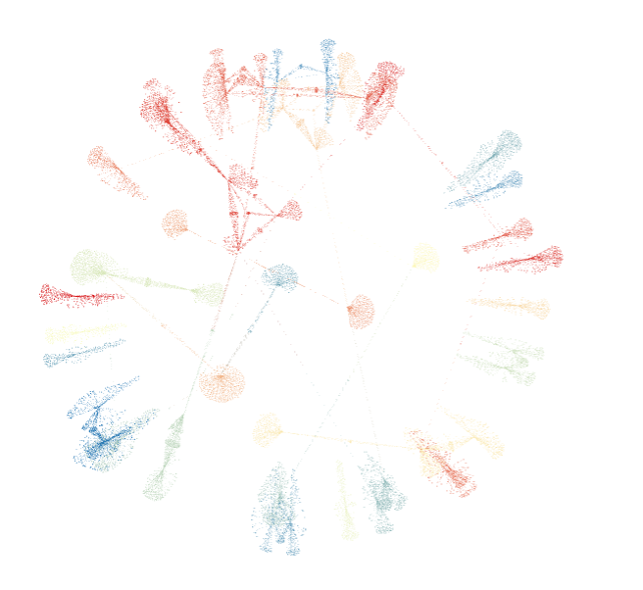

In [55]:
from IPython.display import Image
Image(filename = "Picture_gephi.png", width=1000, height=1000)

To our surprise, by first using the Yifan Hu method to draw the graph and then applying the Louvain algorithm to find communities, the layout configuration overlaps perfectly with the communities found. The result we got from this two step process is the following.
The insight we gain from this graph is that most of the nodes that have a high degree centrality are connected to nodes that in turn are not connected to other nodes. Moreover, nodes with high degree centrality have the tendency to connect communities with each other either directly or through some other nodes between communities. We can therefore clearly visualize not only books having a lot of other books purchased with them, but also what are the books one has to co-purchase to pass from one community to another. For recommendations this means that there’s a trade off between proposing a book to be co-purchased with another one but that reduces the probability of having a third book inserted in the cart or choosing a book that increments this probability. 

## Communities insights

In [66]:
from community import community_louvain
communities =community_louvain.best_partition(g)

[Text(0, 0, 'book'),
 Text(1, 0, 'subject'),
 Text(2, 0, 'general'),
 Text(3, 0, 'nonfict'),
 Text(4, 0, 'philosophi'),
 Text(5, 0, 'histori'),
 Text(6, 0, 'literatur'),
 Text(7, 0, 'fiction'),
 Text(8, 0, 'spiritu'),
 Text(9, 0, 'religion'),
 Text(10, 0, 'polit'),
 Text(11, 0, 'z'),
 Text(12, 0, 'classic'),
 Text(13, 0, 'author'),
 Text(14, 0, 'christian'),
 Text(15, 0, 'store'),
 Text(16, 0, 'roman'),
 Text(17, 0, 'theori'),
 Text(18, 0, 'greek'),
 Text(19, 0, 'scienc')]

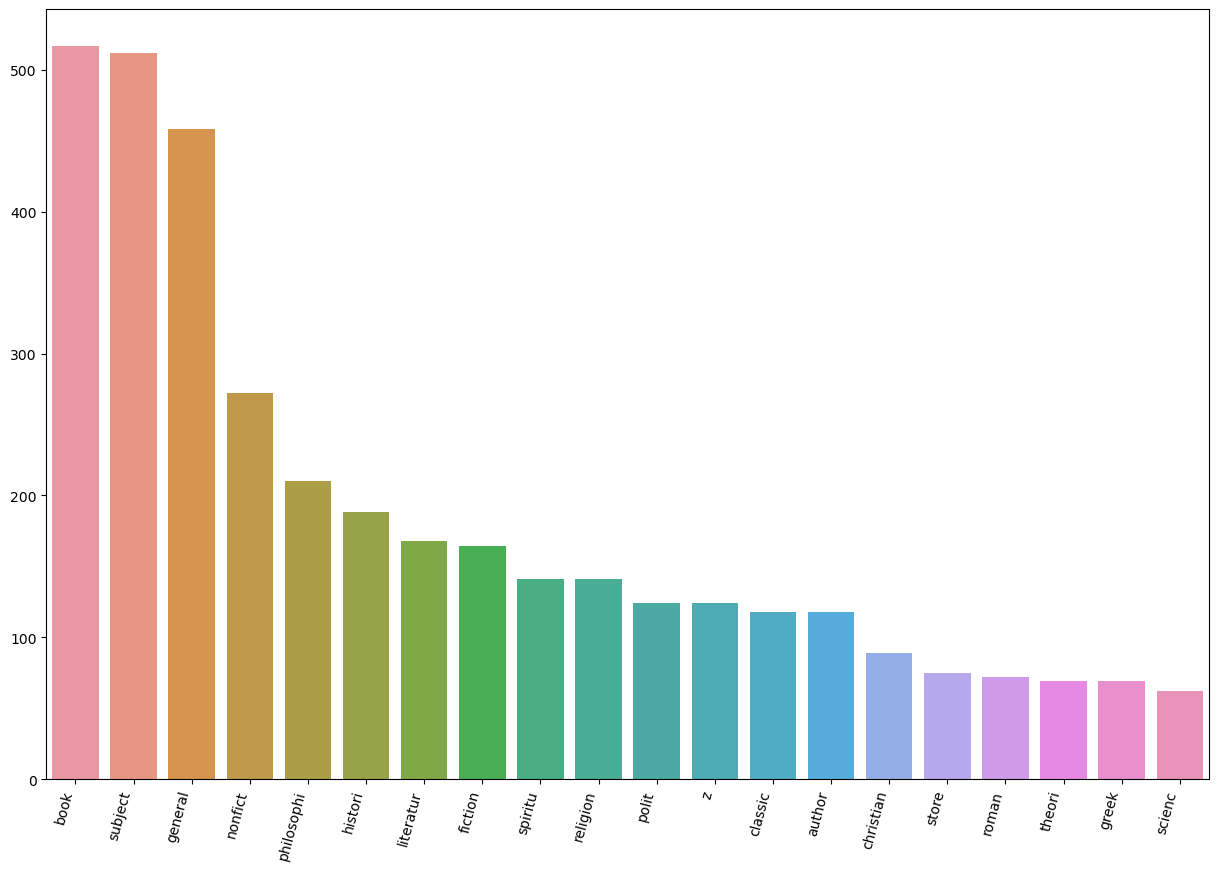

In [68]:
data = pd.read_csv('Modularity_class_sample.csv')
data_5 = data[data['modularity_class'] == 5]

l = list(data_5['Id'])
m = list(amazonBooks.items())
categories = []

for node in l:
    for book in m:
        if node == book[0]:
            categories.append(book[1]['Categories'])
from collections import Counter
cat = []
for i in categories:
    m = i.split()
    for l in m:
        cat.append(l)
        
occur = Counter(cat)

sorted_dict = {}
sorted_keys = sorted(occur, key=occur.get, reverse=True)  

for w in sorted_keys:
    sorted_dict[w] = occur[w]
    
keys = list(sorted_dict.keys())[:20]
vals = list(sorted_dict.values())[:20]
a = sns.barplot(x=keys, y = vals)
a.set_xticklabels(a.get_xticklabels(), rotation=75, horizontalalignment='right')

[Text(0, 0, 'book'),
 Text(1, 0, 'subject'),
 Text(2, 0, 'general'),
 Text(3, 0, 'nonfict'),
 Text(4, 0, 'philosophi'),
 Text(5, 0, 'histori'),
 Text(6, 0, 'literatur'),
 Text(7, 0, 'fiction'),
 Text(8, 0, 'spiritu'),
 Text(9, 0, 'religion'),
 Text(10, 0, 'polit'),
 Text(11, 0, 'z'),
 Text(12, 0, 'classic'),
 Text(13, 0, 'author'),
 Text(14, 0, 'christian'),
 Text(15, 0, 'store'),
 Text(16, 0, 'roman'),
 Text(17, 0, 'theori'),
 Text(18, 0, 'greek'),
 Text(19, 0, 'scienc')]

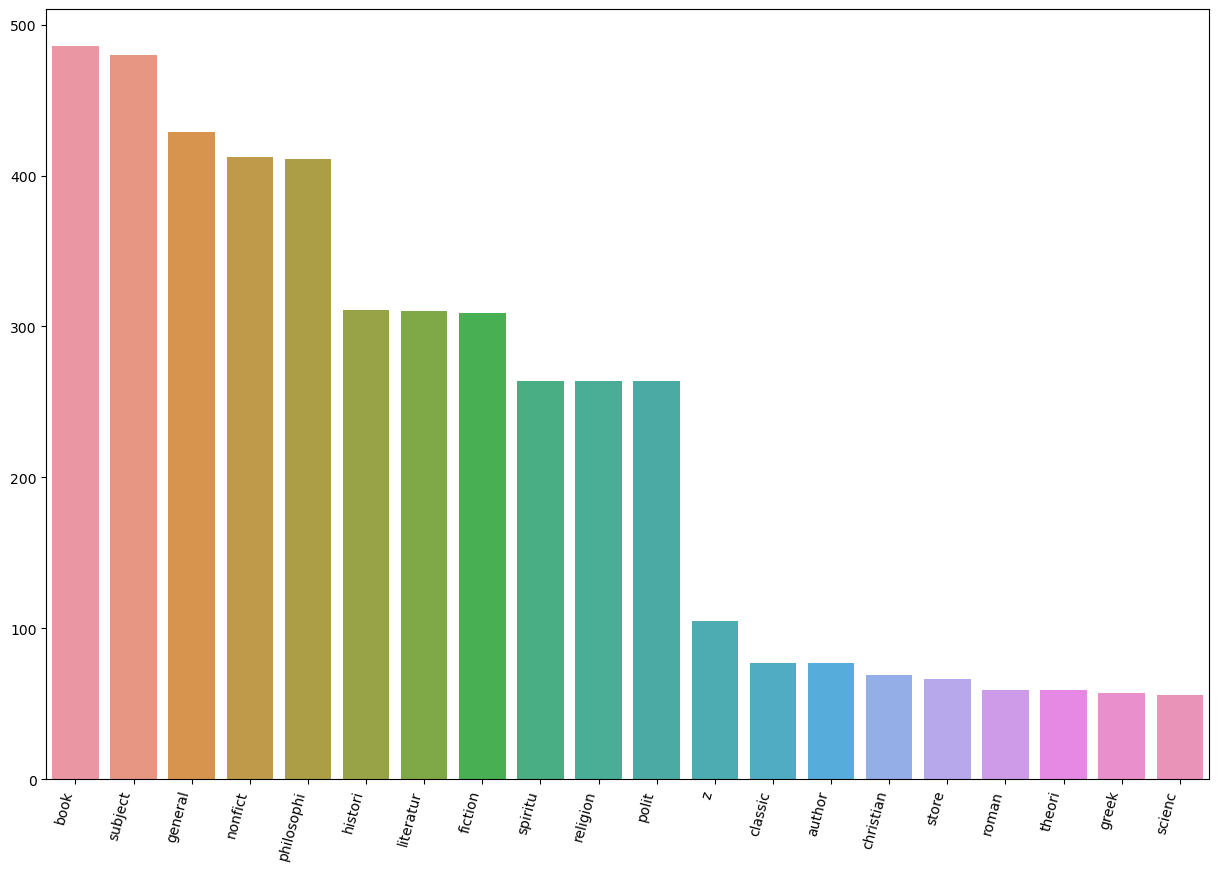

In [69]:
data_3 = data[data['modularity_class'] == 3]

l = list(data_3['Id'])
m = list(amazonBooks.items())
categories = []

for node in l:
    for book in m:
        if node == book[0]:
            categories.append(book[1]['Categories'])

cat = []
for i in categories:
    m = i.split()
    for l in m:
        cat.append(l)
        
occur = Counter(cat)

sorted_dict = {}
sorted_keys = sorted(occur, key=occur.get, reverse=True)  

for w in sorted_keys:
    sorted_dict[w] = occur[w]
    
keys = list(sorted_dict.keys())[:20]
vals = list(sorted_dict.values())[:20]
b = sns.barplot(x=keys, y = vals)
b.set_xticklabels(a.get_xticklabels(), rotation=75, horizontalalignment='right')

[Text(0, 0, 'book'),
 Text(1, 0, 'subject'),
 Text(2, 0, 'general'),
 Text(3, 0, 'nonfict'),
 Text(4, 0, 'philosophi'),
 Text(5, 0, 'histori'),
 Text(6, 0, 'literatur'),
 Text(7, 0, 'fiction'),
 Text(8, 0, 'spiritu'),
 Text(9, 0, 'religion'),
 Text(10, 0, 'polit'),
 Text(11, 0, 'z'),
 Text(12, 0, 'classic'),
 Text(13, 0, 'author'),
 Text(14, 0, 'christian'),
 Text(15, 0, 'store'),
 Text(16, 0, 'roman'),
 Text(17, 0, 'theori'),
 Text(18, 0, 'greek'),
 Text(19, 0, 'scienc')]

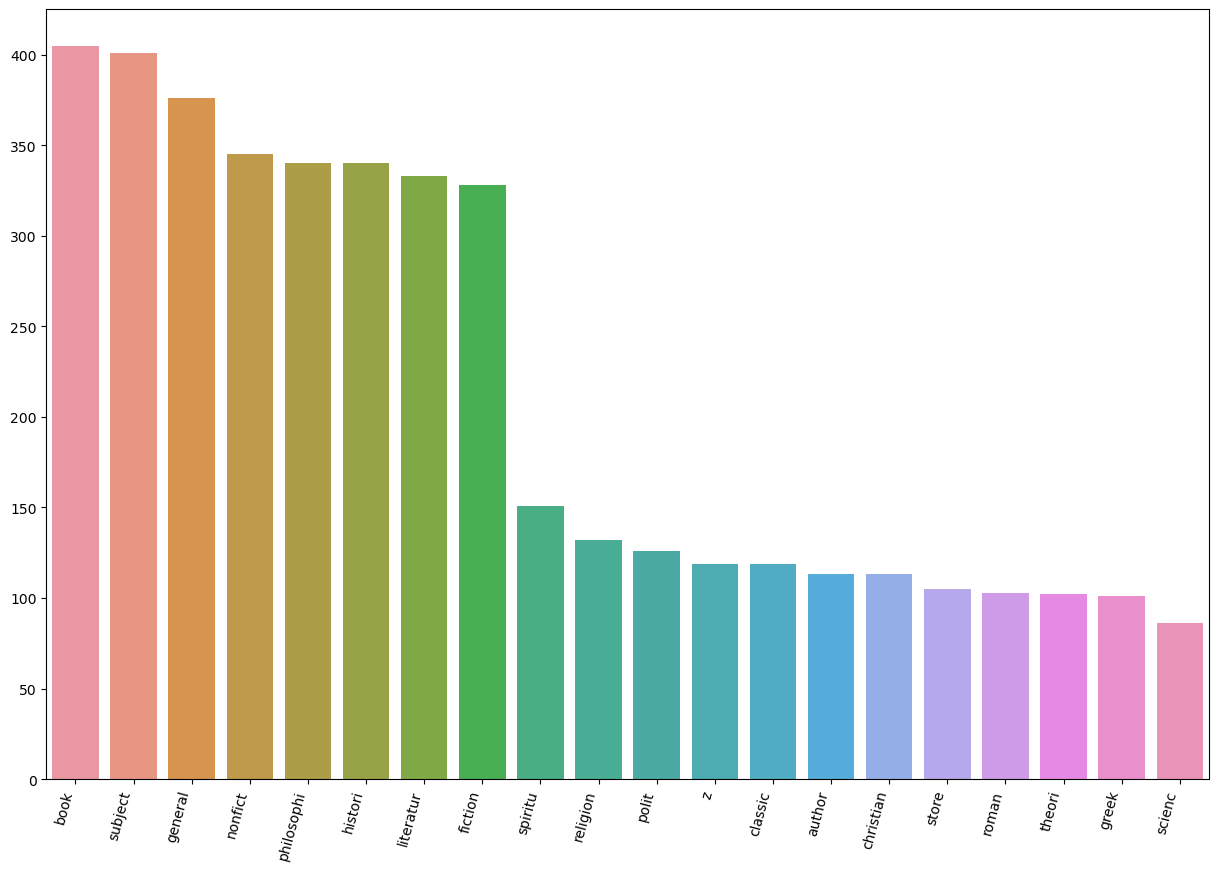

In [70]:
data_17 = data[data['modularity_class'] == 17]

l = list(data_17['Id'])
m = list(amazonBooks.items())
categories = []

for node in l:
    for book in m:
        if node == book[0]:
            categories.append(book[1]['Categories'])

cat = []
for i in categories:
    m = i.split()
    for l in m:
        cat.append(l)
        
occur = Counter(cat)

sorted_dict = {}
sorted_keys = sorted(occur, key=occur.get, reverse=True)  

for w in sorted_keys:
    sorted_dict[w] = occur[w]
    
keys = list(sorted_dict.keys())[:20]
vals = list(sorted_dict.values())[:20]
c = sns.barplot(x=keys, y = vals)
c.set_xticklabels(a.get_xticklabels(), rotation=75, horizontalalignment='right')